# Lorenz 63 Linear Response

A notebook to do some quick informal stuff with L63 Linear Response

Working Notes:
- Looks like I have similar plot to Reick in terms of accuracy condition. Next step is to compute Response function by perturbing at different frequencies.

In [1]:
import tlorenz63 as tl63
from tlorenz63 import make_observations

# Standard Imports
import numpy as np
from scipy.stats import linregress
import os
import xarray as xr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Linear Response Experiment. 

Am attempting to reproduce Reick Frequency figure to verify linear response

In [2]:
# Initialisation
X0=np.random.rand()
Y0=np.random.rand()
Z0=np.random.rand()
dx0=np.random.rand()
dy0=np.random.rand()
dz0=np.random.rand()

transient = 10
T = 2500 # Integration time
dt = 5.e-3
num_obs = int(T/dt)
obs_freq = dt

### No Perturbation

Solving L63 with no perturbation.

In [3]:
# Definining Integrator and Observer

runner = tl63.Integrator(X_init=X0, Y_init=Y0, Z_init=Z0, dx_init=dx0, dy_init=dy0, dz_init=dz0, dt=dt)
looker = tl63.TrajectoryObserver(runner)

In [4]:
runner.integrate(transient)

In [5]:
make_observations(runner, looker, num_obs, obs_freq)
no_pert_obs = looker.observations

/rds/general/user/cfn18/home/L63-Linear-Response/tlorenz63.py:58: RuntimeWarning: overflow encountered in double_scalars
  dzdt = (Y * dx) + (X * dy) - (self.b * dz)
/rds/general/user/cfn18/home/L63-Linear-Response/tlorenz63.py:58: RuntimeWarning: invalid value encountered in double_scalars
  dzdt = (Y * dx) + (X * dy) - (self.b * dz)


### Perturbation Runs

Following Reick, we use a cosine perturbation of varying strengths

In [6]:
f = 20 # Frequency of perturbation
omega = f * 2 * np.pi
switch_on_time = transient

In [7]:
# Defining perturbations, these are designed to perturb r in the L63 equations

def cos_perturbation(state, time, *args):
    eps = args[0]
    omega = args[1]
    x = state[0]
    perturbation = eps * np.cos(omega * time) * x
    return np.array([0, perturbation, 0])

def sin_impulse(state, t_state, time, *args):
    if (time == switch_on_time):
        print(f'Did Impulse at {time}')
        eps = args[0]
        omega = args[1]
        dx = t_state[0]
        perturbation = eps * np.sin(omega * time) * dx
        return np.array([0, perturbation, 0])
    return np.zeros(3) 

In [8]:
# # Performing Perturbation Run for varying strengths of epsilon

# perturbed_observations = []
# strengths = [1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2, 0.1, 0.5, 0.7, 1, 2, 5]
# for eps in tqdm(strengths):
#     print(f'Working on run with eps = {eps}')
#     runner = tl63.PerturbedIntegrator(perturbation_field=cos_perturbation, p_args=[eps, omega], t_perturbation_field=sin_impulse,
#             tp_args=[eps, omega], X_init=X0, Y_init=Y0, Z_init=Z0, dx_init=dx0, dy_init=dy0, dz_init=dz0)
#     looker = tl63.TrajectoryObserver(runner)
#     runner.integrate(transient)
#     runner.perturbation_on = True
#     perturbation_on_time = runner.time
#     make_observations(runner, looker, num_obs, obs_freq)
#     observations = looker.observations
#     observations.attrs.update({'eps': eps})        
#     epsilon = observations.attrs['eps']
#     save = f'Reick-Experiment/Perturbed-Run-Trajectory/Eps_{epsilon:.1e}'.replace('.','_')
#     observations.to_netcdf(save + '.nc')
#     print(f'Saved to {save}')
    

### Opening Perturbed Run Data

In [9]:
perturbed_data = []
directory = 'Reick-Experiment/Perturbed-Run-Trajectory/'
for file in os.listdir(directory):
    if file.endswith(".nc"):
        ds = xr.open_dataset(directory + file)
        perturbed_data.append(ds)

In [10]:
eq_run = xr.open_dataset('Reick-Experiment/Unperturbed.nc')

### Calculating and Plotting Mean Response

This is a plot of the difference between the mean value of the perturbed $z$ and the mean value of the equilibrium $z$

In [11]:
eq_mean = np.mean(eq_run.Z)

In [12]:
epsilons = []
responses = []
for data in perturbed_data:
    response_ts = data.Z - eq_mean
    mean_response = np.mean(response_ts)
    epsilons.append(data.eps)
    responses.append(mean_response)
epsilons = np.array(epsilons)
mean_responses = np.array(responses)

Looks like linear response only from $0.5$ or so.

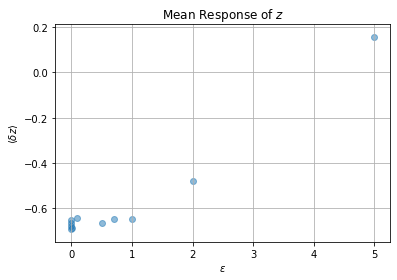

In [13]:
plt.scatter(epsilons, mean_responses, alpha = 0.5)
plt.title('Mean Response of $z$')
plt.ylabel('$\\langle \delta z \\rangle$')
plt.xlabel('$\\epsilon$')
plt.xlabel
plt.grid()

In [14]:
eps_indices = epsilons > 0.3 # Quick Linear regression for eps > 0.3

# Quick Linear Regression
line = linregress(epsilons[eps_indices], mean_responses[eps_indices])

def response_line(eps):
    """Expected response for eps"""
    slope = line[0]
    intercept = line[1]
    return (slope * eps + intercept)

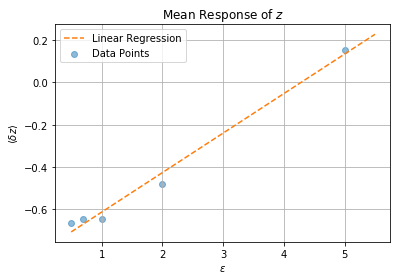

In [15]:
plt.scatter(epsilons[eps_indices], mean_responses[eps_indices], alpha = 0.5, label='Data Points')
x_d = np.linspace(0.5, 5.5, 100)
plt.plot(x_d, [response_line(x) for x in x_d], 'C1--',  label = 'Linear Regression')
plt.title('Mean Response of $z$')
plt.ylabel('$\\langle \delta z \\rangle$')
plt.xlabel('$\\epsilon$')
plt.legend()
plt.grid()

### Accuracy Condition Check

Seeing effect of epsilon on accuracy of respone function calculation

In [16]:
# Function to extract power of a certain frequency
def power(z, freq):
    n = len(z) # Sampling frequency
    dt = obs_freq
    fhat = np.fft.fft(z, n)
    PSD = (fhat * np.conj(fhat))/n
    freq = (1/(dt*n)) * np.arange(n) 
    L = np.arange(1, np.floor(n/2),dtype='int')
    return np.abs(PSD[freq == 20].item())

In [17]:
# Time series of responses
epsilons=[]
response_ts = []
for data in tqdm(perturbed_data):
    epsilons.append(data.eps)
    response = data.Z - eq_mean
    response_ts.append(response)
    
# epsilons = np.array(epsilons)
# response_ts = np.array(response_ts)

In [18]:
powers = []
conditions = []
for data, epsilon in zip(response_ts, epsilons):
    condition = epsilon * omega * (data.Time.max() - data.Time.min()).item()
    conditions.append(condition)
    power = np.abs(2 * np.mean(np.exp(data.Time * omega * 1j) * data)/epsilon)
    powers.append(power.item())

Our condition for accurate numerical results seems to differ from Reick by a factor of about $1000$

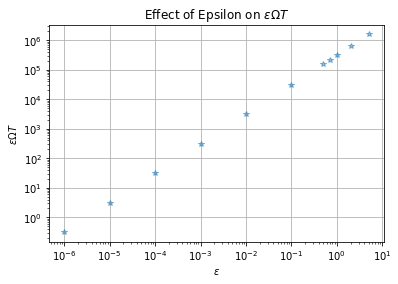

In [19]:
plt.title ('Effect of Epsilon on $\\epsilon \\Omega T$')
plt.ylabel('$\\epsilon \\Omega T$')
plt.xlabel('$\\epsilon$')
plt.plot(epsilons, conditions, '*', alpha = 0.5)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

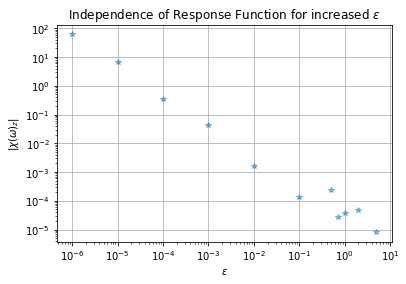

In [20]:
plt.plot(epsilons, powers, '*', alpha = 0.5)
plt.title('Independence of Response Function for increased $\\epsilon$')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$|\\chi(\\omega)_z|$')
plt.xlabel('$\\epsilon$')
# plt.ylim((0, 1.e5))
# plt.xlim((1.e-9, 10))
plt.grid()
plt.show()

## Calculating Response Function

In [21]:
frequencies = np.linspace(0.1, 12, 100)
epsilons = [0.1, 0.5, 1.0]

### Frequency Realm

In [22]:
#test = [cos_perturbation(1, time) for time in unperturbed_z.time]
difference = perturbed_z - unperturbed_z
for i, z in enumerate([unperturbed_z, perturbed_z, difference]):    
    n = len(z[::2]) # Reduce sampling frequency
    dt = obs_freq
    fhat = np.fft.fft(z, n)
    PSD = (fhat * np.conj(fhat))/n
    freq = (1/(dt*n)) * np.arange(n) 
    L = np.arange(1, np.floor(n/2),dtype='int')
    

#     ## Power Spectrum
#     plt.plot(freq[L], PSD[L])
#     plt.yscale('log')
#     plt.xlabel('Frequency')
#     plt.ylabel('Spectrum of $z$')
#     plt.show()

    # Closer look
    indices = ((freq < 10) & (freq >0))
    plt.plot(freq[indices], PSD[indices])
    #plt.plot(freq, PSD)
    #plt.ylim(1.e-3, 1.e3)
    plt.xlabel('Frequency')
    plt.yscale('log')
    label = ['Unperturbed', 'Perturbed','Difference']
    plt.title(f'Specturm of $z$ - {label[i]}')
    plt.show()

NameError: name 'perturbed_z' is not defined

In [ ]:
difference = perturbed_z - unperturbed_z